<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Initial-conditions" data-toc-modified-id="Initial-conditions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial conditions</a></span><ul class="toc-item"><li><span><a href="#Save-these-into-a-dict-for-later-use" data-toc-modified-id="Save-these-into-a-dict-for-later-use-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Save these into a dict for later use</a></span></li></ul></li><li><span><a href="#Steady-state" data-toc-modified-id="Steady-state-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Steady state</a></span></li><li><span><a href="#Transient-behavior" data-toc-modified-id="Transient-behavior-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Transient behavior</a></span></li></ul></div>

# Introduction

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:


def avg(Di, Dj):
    """
    Computes the harmonic average between two values Di and Dj
    Returns 0 if either of them is zero
    """
    if (Di * Dj) == 0:
        return 0
    else:
        return 2 / (1 / Di + 1 / Dj)

In [ ]:
def Build_1D_Inhomo_Matrix_Source(bc_left, bc_right, n, D, Width, poro, Q):
    """
    Constructs a coefficient matrix and an array with varying diffusion coefficient and a source term
    Parameters:
    --------------
    bc_left: (float)  left boundary condition
    bc_right: (float) right boundary conditions
    n (int): amounts of cells
    D (float array): values of the diffusion coefficient
    Width (float): Total phyiscal width of the domain
    poro (float): porosity value
    Q (float array): volumetric source term
    Returns the matrix A, and the array b to solve the
    discretized 1D diffusion problem Ax = b

    ----------
    """
    Matrix = np.zeros((n, n))
    RHS = np.zeros(n)
    dx = Width / (n - 1)
    coef = poro / dx / dx
    for i in range(n):
        if i == 0:
            RHS[i] = bc_left
            Matrix[i,i] = 1
        elif i == n - 1:
            RHS[i] = bc_right
            Matrix[i, i] = 1
        else:
            RHS[i] = Q[i]
            East = coef * avg(D[i], D[i + 1])
            West = coef * avg(D[i], D[i - 1])
            Matrix[i, i] = East + West
            Matrix[i, i + 1] = -East
            Matrix[i, i - 1] = -West
    return Matrix, RHS

# Initial conditions

In [4]:
c_left = 1
c_right = 0
n = 50
Diff = 2e-9
D = Diff * np.ones(n)
Q = np.zeros(n)
Q[int(n / 4) : int(n / 2)] = 0.5e-8  # mg/L/s
Width = 2
poro = 0.4
nTstp = 200
dt = 1.0e7

c_init = np.zeros((nTstp, n))

comment about cell copy
autograde at hump half way to equilibrium
Units -- conversion from seconds to days
comment units
timestep 60, cell 20

## Save these into a dict for later use

In [5]:
init_dict = dict(
    c_left=c_left,
    c_right=c_right,
    c_init=c_init,
    n=n,
    Diff=Diff,
    D=D,
    Q=Q,
    Width=Width,
    poro=poro,
    nTstp=nTstp,
    dt=dt,
)

# Steady state

Text(0, 0.5, 'Concentration (mg/L)')

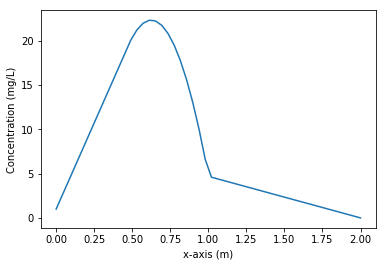

In [6]:
x = np.linspace(0, Width, n)
A, b = Build_1D_Inhomo_Matrix_Source(c_left, c_right, n, D, Width, poro, Q)

c_final = np.linalg.solve(A, b)
plt.plot(x, c_final, label="Concentration")
plt.xlabel("x-axis (m)")
plt.ylabel("Concentration (mg/L)")

# Transient behavior

In [ ]:
def calc_conc(
    Diff=None,
    D=None,
    Width=None,
    c_left=None,
    c_right=None,
    poro=None,
    Q=None,
    c_init=None,
    n=None,
    nTstp=None,
    dt=None,
):

    x = np.linspace(0, Width, n)
    A, b = Build_1D_Inhomo_Matrix_Source(c_left, c_right, n, D, Width, poro, Q)

    c = c_init
    Abis = np.zeros((n, n))
    Bbis = np.zeros(n)
    for t in range(nTstp - 1):
        for i in range(n):
            Abis[i,i] = poro/dt
            Bbis[i] = c[t,i]*poro/dt
        Aa = A + Abis
        bb = b + Bbis
        cnew = np.linalg.solve(Aa, bb)
        c[t + 1,:] = cnew
    return x, c


x, c = calc_conc(**init_dict)

plt.plot(x, c_final, label="Asymptotic concentration")
plt.plot(x, c[0,:], label="Initial concentration")
plt.plot(x, c[10,:], label="Concentration after 10 timestep")
plt.plot(x, c[30,:], label="Concentration after 30 timesteps")
plt.plot(x, c[60,:], label="Concentration after 60 timesteps")
plt.plot(x, c[nTstp - 1,:], label="Concentration after 100 timesteps")
plt.xlabel("x-axis (m)")
plt.ylabel("Concentration (mg/L)")
plt.legend();

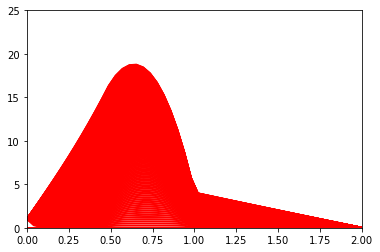

In [8]:
def make_animation(init_dict):
    image_list = []
    x, c = calc_conc(**init_dict)
    fig, ax = plt.subplots()
    ax.set_xlim((0, 2.0))
    ax.set_ylim((0, 25.0))
    nsteps, nvals = c.shape
    for index in range(nsteps):
        line = ax.plot(x, c[index, :], "r-", lw=2)
        image_list.append(line)
    return fig, image_list


fig, image_list = make_animation(init_dict)

In [9]:
movie=False
if movie:
    import matplotlib.animation as animation
    from IPython.display import HTML

    anim = animation.ArtistAnimation(
        fig, image_list, interval=50, blit=True, repeat_delay=1000
    )

In [10]:
if movie:
    [HTML(anim.to_html5_video())